In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SeqUtils import molecular_weight, MeltingTemp as mt
from nupack import *
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [77]:
def verify_na(sequence):
    '''This code verifies if a sequence is a DNA or RNA'''
    # set the input sequence
    seq = set(sequence)
     
    # confirm if its elements is equal to the
    # set of valid DNA bases
    # Use a union method to ensure the sequence is
    # verified if does not contain all the bases
    if seq == {"A", "T", "C", "G"}.union(seq):
        return "DNA"
    elif seq == {"A", "U", "C", "G"}.union(seq):
        return "RNA"
    elif seq == {"A", "C", "G"}.union(seq):
        return "RNA"
    elif seq == {"C", "G"}.union(seq):
        return "RNA"
    else:
        return False

def _complement(sequence):
    '''This function returns a reverse complement 
    of a DNA or RNA strand'''
    verified = verify_na(sequence)
    if verified == "DNA":
        # complement strand
        seq = sequence.replace("A", "t").replace(
            "C", "g").replace("T", "a").replace("G", "c")
        seq = seq.upper()
        # reverse strand
        seq = seq[::-1]
        return seq
 
    elif verified == "RNA":
       
        # complement strand
        seq = sequence.replace("A", "u").replace(
            "C", "g").replace("U", "a").replace("G", "c")
        seq = seq.upper()
         
        # reverse strand
        seq = seq[::-1]
        return seq
    else:
        return False
    
def dna_to_mrna(inputDNA):
    '''This function reverts the DNA sequences to RNA transcripts'''
    MRNA = ''
    for code in inputDNA:
        if code == 'T':
            MRNA = MRNA + 'U'
        if code == 'C':
            MRNA = MRNA + 'C'
        if code == 'A':
            MRNA = MRNA + 'A'
        if code == 'G':
            MRNA = MRNA + 'G'

    return MRNA

def score_match(subject, query, subject_start, query_start, length):
    score = 0
    # for each base in the match
    for i in range(0,length):
        # first figure out the matching base from both sequences
        subject_base = subject[subject_start + i]
        query_base = query[query_start + i]
        # then adjust the score up or down depending on 
        # whether or not they are the same
        if subject_base == query_base:
            score = score + 1
        else:
            score = score - 1
    return score

def try_all_matches(subject, query):

 # try every possible value for subject start and query start
    for subject_start in range(0,len(subject)):
        for query_start in range(0,len(query)):

            # try every possible value for length of match    
            # the length can never be longer than the length of the shortest 
            # input sequence, so it doesn't matter whether we use the query or the subject
            for length in range(1,len(query)):

                # this will generate lots of proposed matches which go beyond the 
                # length of one of the input sequences
                # so we will only try to score those that fit within the two sequences
                if (subject_start + length < len(subject) and query_start + length < len(query)):
                    score = score_match(subject, query, subject_start, query_start, length)
                    print(subject_start, query_start, length, score)

def try_all_matches(subject, query, score_limit):
    for subject_start in range(0,len(subject)):
        for query_start in range(0,len(query)):
            for length in range(0,len(query)):
                if (subject_start + length < len(subject) and query_start + length < len(query)):
                    score = score_match(subject, query, subject_start, query_start, length)
                    # only print a line of output if the score is better than some limie
                    if (score >= score_limit):
                        print(subject_start, query_start, length, score)

def pretty_print_match(subject, query, subject_start, query_start, length):

    # first print the start/stop positions for the subject sequence
    print(str(subject_start) + (' ' * length) + str(subject_start+length))

    # then print the bit of the subject that matches
    print(' ' + subject[subject_start:subject_start+length])

    # then print the bit of the query that matches
    print(' ' + query[query_start:query_start+length])

    # finally print the start/stop positions for the query
    print(str(query_start) + (' ' * length) + str(query_start+length))

    print('\n--------------------\n')

def try_all_matches(subject, query, score_limit):
    for subject_start in range(0,len(subject)):
        for query_start in range(0,len(query)):
            for length in range(0,len(query)):
                if (subject_start + length < len(subject) and query_start + length < len(query)):
                    score = score_match(subject, query, subject_start, query_start, length)
                    # only print a line of output if the score is better than some limie
                    if (score >= score_limit):
                        #print('Score : ' + str(score))
                        query_end = query_start+length
                        #pretty_print_match(subject, query, subject_start, query_start, length)
                        return True, query_start, query_end

    if (score < score_limit):
        return False, query_start, query_start+length
                        

In [78]:
def mmp9_complement(seq):
    '''This function checks the complement of the sequence with the MMP9 mRNA and ouputs its complementary sequence plus/minus 15 bp'''

    mmp9_rna = open('rna_mmp9.txt', 'r').read() # Open mRNA of MMP9 sequence
    mmp9_rna = mmp9_rna.replace('\n', '')
    mmp9_rna = mmp9_rna.replace('T', 'U')

    seq_length = len(seq)
    equal = try_all_matches(seq, mmp9_rna, seq_length-2) # Find the MMP9 nucleotide sequence complement to our input nucleotids
    
    if equal[0] == True: # Choose the index values of the MMP9 gene which correspond to the complement sequence
        if equal[1] <= 15:
            q_st = 0
            q_ed = equal[2] + 15
        elif equal[2] >= len(mmp9_rna)-15: 
            q_st = equal[1] - 15
            q_ed = equal[2] + abs(len(mmp9_rna) - equal[2])
        else:
            q_st =  equal[1] - 15
            q_ed = equal[2] + 15

        mmp9_seq = mmp9_rna[q_st:q_ed]
    else:
        mmp9_seq = np.NaN

    return mmp9_seq # Return the MMP9 sequence complement ot the input nucleotids

In [79]:
def hairpin_dataset(sequence):
    '''
    Function that will generate a dataframe with all the possible hairpin sequences given a silencing DNA 
    Input: a class type dna_sequence
    Output: dataframe containing all the possible hairpin structures with either 2 or 4 'GC' content
    '''
    # Define the nucleotides
    nucleotides = ['A', 'C', 'G', 'U']
    reverse_complementary_hairpins =[]
    seq_complement=''

    # Define panda where sequences will be stored
    hairpin_pd = pd.DataFrame()

    # Generate all possible combinations of nucleotides of length 7 as this is the hairpin length with over 1 possibility with 2,4 'GC' content
    sequences = list(itertools.product(nucleotides, repeat=7))
    # Filter for sequences that contain 3 (or 2) 'GC' nucleotides
    filtered_sequences = [seq for seq in sequences if ''.join(seq).count('GC') == 2 or ''.join(seq).count('GC') == 4]
    # Convert list of tuples to list of strings
    list_of_strings = [''.join(t) for t in filtered_sequences]
    # Get a list of the reverse complemente haipin sequences
    for seq in list_of_strings:
        seq_complement = _complement(seq)
        reverse_complementary_hairpins.append(seq_complement)
        seq_complement=''

    # We construct the hairpin sequences by adding the hairpin complementary bp to each end of the siRNA sequence
    hairpins = []
    seq_name = []
    hairpin_length = []
    hairpin_mw = []
    hairpin_mt = []
    mmp9_snippets = []
    for seq, rev in zip(list_of_strings, reverse_complementary_hairpins):
        hairpin = seq + sequence.sequence + rev
        hairpins.append(hairpin)
        seq_name.append(sequence.name)
        hairpin_length.append(len(hairpin))
        hairpin_mw.append(molecular_weight(hairpin, 'RNA'))
        hairpin_mt.append(mt.Tm_Wallace(hairpin))
    
    # Define dataframe values and columns
    hairpin_pd['Name'] = seq_name
    hairpin_pd['Hairpin'] = hairpins
    hairpin_pd['Length'] = hairpin_length
    hairpin_pd['MW'] = hairpin_mw
    hairpin_pd['Tm(°C)'] = hairpin_mt

    return hairpin_pd

In [129]:
def aso_model(seq, hairpin_panda):
    '''
    Model that will predict the:
        Free Energy
        MFE
        Base Pair Probability Matrix
    For both the hairpin and the hybridisation between the hairpin and the MMP9 mRNA. This will be done for the full list of hairpins given
    Input: DataFrame containing the generated hairpin structures, dna_sequence class
    Output: DataFrame with the columns corresponding to the above calculated parameters added to the inputed DataSet
    '''
    
    # Define physical model 
    mmp9_model = Model(material='rna06', celsius=37, sodium=0.5, magnesium=0.01, ensemble='stacking')
    # Define the energy gap (kcal/mol) for calculating suboptimal structures
    gap = 1.1

    # Calculate hairpin sequences stability analysis and complex(hairpin+MMP9) sequences stability analysis
    # Define lists to store dG and MFE values and bp probabilites
    hairpin_mfe = []
    hairpin_dg = []
    hairpin_p = []

    hyb_mfe = []
    hyb_dg = []
    hyb_p = []

    for hairpin in hairpin_panda['Hairpin']:
        # Define the strands
        hp_st = Strand(hairpin, name='hp_st')
        mmp9_st = Strand(seq.gene_snippet, name='mmp9_st')
        # Define the complex of interest
        hp_complex = Complex([hp_st]) # Secondary structure of hairpin folding
        hyb_complex = Complex([hp_st, mmp9_st]) # Hybridisation between hairpin and gene of interest
        # Define the complex set to contain only one complex for both cases
        hp_set = ComplexSet(strands={hp_st: 1e-8}, complexes=SetSpec(max_size=1, include=[hp_complex]))
        hyb_set = ComplexSet(strands={hp_st: 1e-8, mmp9_st: 1e-8}, complexes=SetSpec(max_size=1, include=[hyb_complex]))
        print(hyb_set)
        # Analyze the complex 
        # Calculate pfunc, pairs, mfe, subopt
        hp_result = complex_analysis(hp_set, compute=['pfunc', 'pairs', 'mfe', 'subopt'], 
                                 options={'energy_gap': gap}, model=mmp9_model)
        
        hyb_result = complex_analysis(hyb_set, compute=['pfunc', 'pairs', 'mfe', 'subopt', 'ensemble_size'], 
                                 options={'energy_gap': gap}, model=mmp9_model)
        print(hyb_result)
        # Store predicted dG and MFE values and bp probabilites
        hairpin_result = hp_result[hp_complex]
        hyb_result = hyb_result[hyb_complex, 2]
        print(hyb_result)
        
        hairpin_dg.append(hairpin_result.free_energy)
        hairpin_mfe.append(hairpin_result.mfe[0][1])
        hairpin_p.append(hairpin_result.pairs.to_array())
        hyb_dg.append(hyb_result.free_energy)
        hyb_mfe.append(hyb_result.mfe[0][1])
        hyb_p.append(hyb_result.pairs.to_array())
    
    hairpin_panda['Hairpin_dG (kcal/mol)'] = hairpin_dg
    hairpin_panda['Hairpin_MFE (kcal/mol)'] = hairpin_mfe
    hairpin_panda['Hairpin_Pb'] = hairpin_p

    hairpin_panda['Hyb_dG (kcal/mol)'] = hyb_dg
    hairpin_panda['Hyb_MFE (kcal/mol)'] = hyb_mfe
    hairpin_panda['Hyb_Pb'] = hyb_p

    # Now, we need to clean the rows in which either the MFE of hybridisation or hairpin are positive
    # We also need to clean the rows in which the MFE for hybridisation is higher than the hairpin one - as once inside the cell they will not open to bind to the mRNA of MMP9
    hairpin_panda = hairpin_panda[(hairpin_panda['Hairpin_MFE (kcal/mol)'] < 0) & (hairpin_panda['Hyb_MFE (kcal/mol)'] < 0) & (hairpin_panda['Hairpin_MFE (kcal/mol)'] > hairpin_panda['Hyb_MFE (kcal/mol)'])]

    return hairpin_panda

In [81]:
def clean_model(hairpin_pd, display):
    '''
    Function which takes the statistical distributions of the generated dataset and optimise the most optimal outputs.
    It also displays the data if chosen to do so by the flag variable 'display' to be set to True
    '''
    # The difference between hairpins and hybridisation complexes will be used to eliminate all structures with overlapping energy values
    diff_mfe = np.subtract(hairpin_pd['Hyb_MFE (kcal/mol)'], hairpin_pd['Hairpin_MFE (kcal/mol)']) # Calculate the difference between complexes 
    hairpin_pd['MFE_Diff (kcal/mol)'] = diff_mfe
    hairpin_pd['MFE_Diff_Derivative'] = np.gradient(diff_mfe)+np.min(hairpin_pd['Hairpin_MFE (kcal/mol)']) # Append the list of differences into the dataframe

    # Let's remove the rows where the values for both Hairpin and Hybridisation complex match, as well as those lying 1-std around that point
    # Take the difference between distributions and build a a new distribution with those values, then calculate the statistics and dicriminate accordingly

    diff_mean = np.mean(diff_mfe)
    diff_std = np.std(diff_mfe)
    sig_diff = abs(diff_mean) + 2.3*diff_std

    # Remove rows from the database where the difference between the hairpin and hybridised form not on the range mean+std
    hairpin_pd_cleaned = hairpin_pd[((hairpin_pd['Hairpin_MFE (kcal/mol)'] - hairpin_pd['Hyb_MFE (kcal/mol)']) > sig_diff)]
    
    # To clean the data further, we can add the diagonal values from the probability base pair matrix to assess which sequences will have a higher predicted 
    # base pairing and hence will hybridise and group into a hairpin at higher rates while mitigating cross-talk
    hyb_pb = []
    hp_pb = []
    # Calculate diagonal sum of probability matrix values
    for pb_hair, pb_hyb in zip(hairpin_pd_cleaned['Hairpin_Pb'], hairpin_pd_cleaned['Hyb_Pb']):
        pb_ha, pb_hy = np.asarray(pb_hair), np.asarray(pb_hyb)
        hp_pb.append(np.trace(pb_ha))
        hyb_pb.append(np.trace(pb_hy))

    # Add the calculated values in our cleaned database
    hairpin_pd_cleaned.insert(13, 'D_Pb_Hairpin', hp_pb, True)
    hairpin_pd_cleaned.insert(14, 'D_Pb_Hyb', hyb_pb, True)

    # Remove the rows of which values are lower than the mean values of the sum over the diagonal probabilities
    hairpin_pd_optimised = hairpin_pd_cleaned[(hairpin_pd_cleaned['D_Pb_Hairpin'] > np.mean(hp_pb)) & (hairpin_pd_cleaned['D_Pb_Hyb'] > np.mean(hyb_pb))]
    
    if display == True:
        # Plot histogram with the distribution of energies
        fig, ax = plt.subplots()
        fig.set_size_inches(13, 6)
        ax.set(xlabel='MFE (kcal/mol)')
        sns.set_style("darkgrid")
        sns.set(color_codes=True)
        sns.set(palette="muted")
        sns.histplot([hairpin_pd['Hairpin_MFE (kcal/mol)'], hairpin_pd['Hyb_MFE (kcal/mol)']], 
                        stat="density", bins=250, common_norm=False, kde=True, fill=True, ax=ax)
        plt.show()

        # Plot histogram with the distribution of energies and the first derivative of the differnces between them to see where there are more minimum values
        fig, ax = plt.subplots()
        fig.set_size_inches(13, 6)
        ax.set(xlabel='MFE (kcal/mol)')
        sns.set_style("darkgrid")
        sns.set(color_codes=True)
        sns.set(palette="muted")
        sns.histplot([hairpin_pd['Hairpin_MFE (kcal/mol)'], hairpin_pd['Hyb_MFE (kcal/mol)'], hairpin_pd['MFE_Diff_Derivative']], 
                     stat="density", bins=250, common_norm=False, kde=True, fill=True, ax=ax)
        plt.show()

        # Plot a histogram to see the difference in energy from the cleaned dataset and check that the overlapping section has been removed
        fig, ax = plt.subplots()
        fig.set_size_inches(13, 6)
        ax.set(xlabel='MFE (kcal/mol)')
        sns.set_style("darkgrid")
        sns.set(color_codes=True)
        sns.set(palette="muted")
        sns.histplot([hairpin_pd_cleaned['Hairpin_MFE (kcal/mol)'], hairpin_pd_cleaned['Hyb_MFE (kcal/mol)']], 
                     stat="density", shrink=2, bins=250, fill=True, kde=True, ax=ax)
        plt.show()
        
        # Bar plot to assess the differences in MFEs between hybrid and hairpin with the optimised sequences: step 1
        # Create a figure and axis with a specific size
        fig, ax = plt.subplots(figsize=(12.8, 6))
        width1 = 0.3
        ar = np.arange(len(hairpin_pd_cleaned['Hairpin'])) # Range values for the set of Hairpin Sequences
        # We plot the data from the dataset for both the Hairpin and the Hybrid complex predicted energies
        ax.bar(ar, abs(hairpin_pd_cleaned['Hairpin_MFE (kcal/mol)']), width=0.3, align='edge', label='Hairpin_MFE (kcal/mol)', color=sns.xkcd_rgb['windows blue'], alpha=0.5)
        ax.bar(ar + width1, abs(hairpin_pd_cleaned['Hyb_MFE (kcal/mol)']), width=0.3, align='edge', label='Hyb_MFE (kcal/mol)', color=sns.xkcd_rgb['orangish'], alpha=0.6)
        ax.set_ylabel('ABS MFE (kcal/mol)', fontsize=14)
        ax.set_title('Predicted ABS values of MFE for both Hairpin and Complex Structures: 1 Optimisation', fontsize=10, weight='bold')
        ax.set_xticks(ar, hairpin_pd_cleaned['Hairpin'], rotation=70, fontweight='bold', fontsize='5', horizontalalignment='right', minor=False)
        ax.legend()
        plt.show()

        # Bar plot to assess the differences in MFEs between hybrid and hairpin with the optimised sequences: step 1
        # Create a figure and axis with a specific size
        fig, ax = plt.subplots(figsize=(12, 4))
        width1 = 0.3
        ar = np.arange(len(hairpin_pd_optimised['Hairpin'])) # Range values for the set of Hairpin Sequences: step 2
        # We plot the data from the dataset for both the Hairpin and the Hybrid complex predicted energies
        ax.bar(ar, abs(hairpin_pd_optimised['Hairpin_MFE (kcal/mol)']), width=0.3, align='edge', label='Hairpin_MFE (kcal/mol)', color=sns.xkcd_rgb['windows blue'], alpha=0.5)
        ax.bar(ar + width1, abs(hairpin_pd_optimised['Hyb_MFE (kcal/mol)']), width=0.3, align='edge', label='Hyb_MFE (kcal/mol)', color=sns.xkcd_rgb['orangish'], alpha=0.6)
        ax.set_ylabel('ABS MFE (kcal/mol)', fontsize=8)
        ax.set_title('Predicted ABS values of MFE for both Hairpin and Complex Structures: 2 Optimisation', fontsize=12, weight='bold')
        ax.set_xticks(ar, hairpin_pd_optimised['Hairpin'], rotation=70, fontweight='bold', fontsize='8', horizontalalignment='right', minor=False)
        ax.legend()
    
    return hairpin_pd_optimised


In [82]:
def control_dataset(hairpin_optimised, seq_c, seq_gene):
    '''
    Function which generates the according control hairpins for a given dataframe of sequences.
    Input: Dataframe with sequences to generate controls for, class dna_sequence containing the control sequence
    Ouput: Dataframe with the control hairpins
    '''
    control_pd = pd.DataFrame()
    control_hairpins = []
    seq_name = []
    hairpin_length = []
    hairpin_mw = []
    hairpin_mt = []
    for idx, seq in zip(hairpin_optimised.index, hairpin_optimised['Hairpin']):
        c_hp = seq[:6] + seq_c.sequence + seq[-6:]
        control_hairpins.append(c_hp)
        seq_name.append(seq_c.name + '' + str(idx))
        hairpin_length.append(len(c_hp))
        hairpin_mw.append(molecular_weight(c_hp, 'RNA'))
        hairpin_mt.append(mt.Tm_Wallace(c_hp))
    
    control_pd['Name'] = seq_name
    control_pd['Hairpin'] = control_hairpins
    control_pd['Length'] = hairpin_length
    control_pd['MW'] = hairpin_mw
    control_pd['Tm(°C)'] = hairpin_mt
    control_pd = aso_model(seq_gene, control_pd)

    return control_pd


In [83]:
class dna_sequence:
    def __init__(self, name, sequence, length, mw, tm):
        self.name = name
        self.sequence = sequence
        self.complement = _complement(self.sequence)
        self.length = length
        self.mw = mw
        self.tm = tm
        self.gene_snippet = mmp9_complement(self.complement) # Chceck

In [84]:
# Define silencing sequences

sq1 = dna_sequence('sq1', 'GGGCAGAGGUGUCU', 14, 4359.9, 50.2)
sq2 = dna_sequence('sq2', 'UUGAGGUCGCCCUCAAAGGUU', 21, 6437.2, 59)
sq3 = dna_sequence('sq3', 'TCGCTGTCAAAGTTCGAGGTG', 21, 6477.2, 57.5)
sq4 = dna_sequence('sq4', 'TTCAGGGCGAGGACCATAGAG', 21, 6520.3, 58.3)
sq5 = dna_sequence('sq5', 'AATTCAGGGCGAGGACCATAG', 21, 6504.3, 56.7)
sq6 = dna_sequence('sq6', 'GCCTCAGAGAATCGCCAGTACT', 22, 6704.4, 58.6)
sq_control = dna_sequence('sq_control', 'UUCUCCGAACGUGUCACGU', 19, 5754.8, 57.5)

In [85]:
# To start with, we would need to double-check if the above sequences have complementariety towards the MMP9 RNA sequence
# First we will upload the sequences of the targetted genes.
# Once, we have double checked that the given sequences do indeed have a complement sequence towards the MMP9 gene
# We will extract and save the correponding sequences +,- 15bp to then perform the hybridization analysis
# The Nupack library used for the complex analysis of hybridization works with sequences up to a certain range, hence the need to split the MMP9 into the sequences which perform the binding
# Then, we construct a database with all the possible harpin sequences which can hybridise with MMP9
# and predict their looping free energies, as well as, the free energies of the hybridisation process between hairpin and MMP9 to see if the process would be spontaneuos and promoted

# First siRNA: sq1
if sq1.gene_snippet != np.NaN:
    sq1_hairpins = hairpin_dataset(sq1)
    sq1_hairpins = aso_model(sq1, sq1_hairpins)
    sq1_hairpins_optimised = clean_model(sq1_hairpins, False)
    sq1_controls = control_dataset(sq1_hairpins_optimised, sq_control, sq1)

else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq1.name)

In [130]:
# Second siRNA: sq1
if sq2.gene_snippet != np.NaN:
    sq2_hairpins = hairpin_dataset(sq2)
    sq2_hairpins = aso_model(sq2, sq2_hairpins)
    sq2_hairpins_optimised = clean_model(sq2_hairpins, False)
    print(sq2_hairpins_optimised)
    sq2_controls = control_dataset(sq2_hairpins_optimised, sq_control, sq2)
    print(sq2_controls)
else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq2.name)

ComplexSet([<Strand hp_st>, <Strand mmp9_st>], include=[<Complex (hp_st)>, <Complex (hp_st+mmp9_st)>, <Complex (mmp9_st)>])
Complex results:
           Complex       Pfunc dG (kcal/mol) MFE (kcal/mol) Ensemble size
0          (hp_st)  3.0001e+10       -14.868        -14.437    3364635272
1        (mmp9_st)  5.3770e+10       -15.228        -14.572     7.367e+12
2  (hp_st+mmp9_st)  2.8556e+38       -54.574        -53.273     4.336e+24


KeyError: (<Complex (hp_st+mmp9_st)>, 2)

UUCUCCGAACGUGUCACGU
AGACACCUCUGCCCUCACCAUGAGCCUCUGGCAGCCCCUGGUCCUGGUGCUCCUGGUGCUGGGCUGCUGCUUUGCUGCCCCCAGACAGCGCCAGUCCACCCUUGUGCUCUUCCCUG
UUCUCCGAACGUGUCACGU
GAGACCUGAGAACCAAUCUCACCGACAGGCAGCUGGCAGAGGAAUACCUGUACCGCUAUGGUUACACUCGGGUGGCAGAGAUGCGUGGAGAGUCGAAAUCUCUGGGGCCUGCGCUG
UUCUCCGAACGUGUCACGU
CUGCUUCUCCAGAAGCAACUGUCCCUGCCCGAGACCGGUGAGCUGGAUAGCGCCACGCUGAAGGCCAUGCGAACCCCACGGUGCGGGGUCCCAGACCUGGGCAGAUUCCAAACCUU
UUCUCCGAACGUGUCACGU
UGAGGGCGACCUCAAGUGGCACCACCACAACAUCACCUAUUGGAUCCAAAACUACUCGGAAGACUUGCCGCGGGCGGUGAUUGACGACGCCUUUGCCCGCGCCUUCGCACUGUGGA
UUCUCCGAACGUGUCACGU
GCGCGGUGACGCCGCUCACCUUCACUCGCGUGUACAGCCGGGACGCAGACAUCGUCAUCCAGUUUGGUGUCGCGGAGCACGGAGACGGGUAUCCCUUCGACGGGAAGGACGGGCUC
UUCUCCGAACGUGUCACGU
CUGGCACACGCCUUUCCUCCUGGCCCCGGCAUUCAGGGAGACGCCCAUUUCGACGAUGACGAGUUGUGGUCCCUGGGCAAGGGCGUCGUGGUUCCAACUCGGUUUGGAAACGCAGA
UUCUCCGAACGUGUCACGU
UGGCGCGGCCUGCCACUUCCCCUUCAUCUUCGAGGGCCGCUCCUACUCUGCCUGCACCACCGACGGUCGCUCCGACGGCUUGCCCUGGUGCAGUACCACGGCCAACUACGACACCG
UUCUCCGAACGUGUCACGU
ACGACCGGUUUGGCUUCUGCC

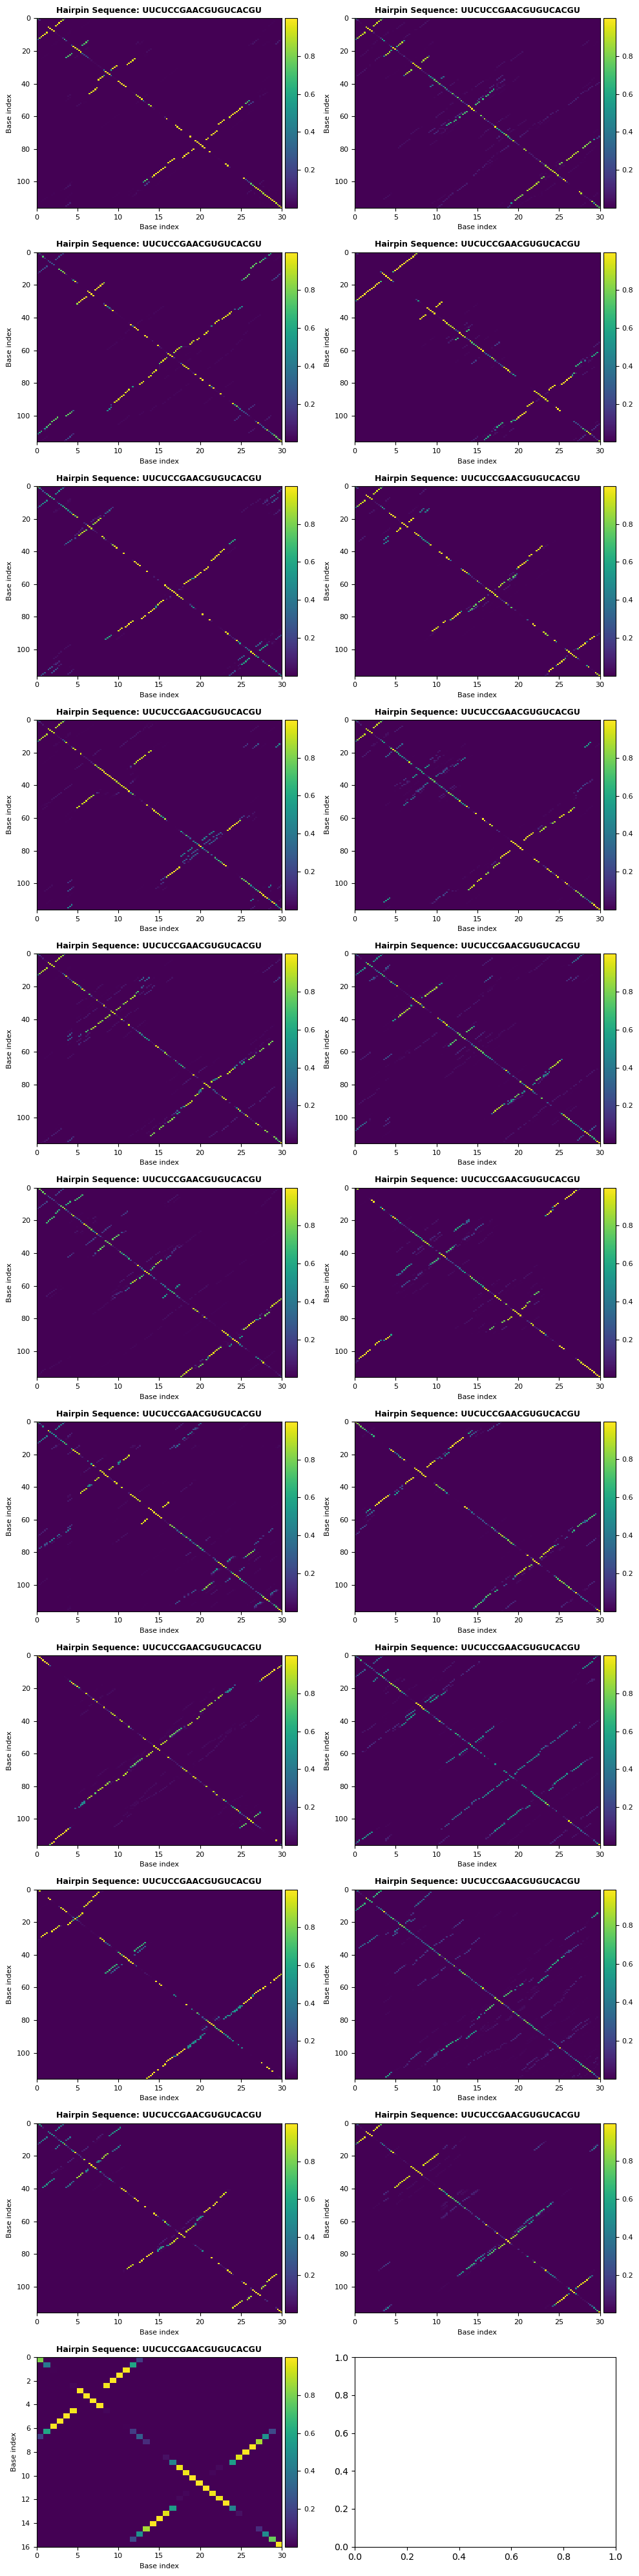

In [122]:
# Checking control sequence does not hybridise with any part of mmp9

mmp9_rna = open('rna_mmp9.txt', 'r').read() # Open mRNA of MMP9 sequence
mmp9_rna = mmp9_rna.replace('\n', '')
mmp9_rna = mmp9_rna.replace('T', 'U')

chunks, chunk_size = len(mmp9_rna), len(mmp9_rna)//20
mmp9_strings = [mmp9_rna[i:i+chunk_size] for i in range(0, chunks, chunk_size)]

control_panda = pd.DataFrame()
# Define physical model 
mmp9_model = Model(material='rna06', celsius=37, sodium=0.5, magnesium=0.01, ensemble='stacking')
# Define the energy gap (kcal/mol) for calculating suboptimal structures
gap = 1.1

mmp9_seqs = []
bp_control = []
for seq in mmp9_strings:
    # Define the strands
    control = Strand(sq_control.sequence, name='hp_st')
    print(control)
    mmp9_st = Strand(seq, name='mmp9_st')
    print(mmp9_st)
    # Define the complex of interest
    hyb_complex = Complex([hp_st, mmp9_st]) # Hybridisation between hairpin and gene of interest
    # Define the complex set to contain only one complex for both cases
    hyb_set = ComplexSet(strands={hp_st: 1e-8, mmp9_st: 1e-8}, complexes=SetSpec(max_size=1, include=[hyb_complex]))
    # Analyze the complex 
    # Calculate pfunc, pairs, mfe, subopt
    c_result = complex_analysis(hyb_set, compute=['pfunc', 'pairs', 'mfe', 'subopt'], 
                                options={'energy_gap': gap}, model=mmp9_model)
    c_result = c_result[hyb_complex]
    mmp9_seqs.append(seq)
    bp_control.append(c_result.pairs.to_array())

control_panda['MMP9 Seq'] = mmp9_seqs
control_panda['bp_Prob'] = bp_control

ig, axs = plt.subplots(nrows=11, ncols=2, figsize=(10, 40))
fig.subplots_adjust(wspace=0.5)
for ax, pb, mmp9 in zip(axs.flat, control_panda['bp_Prob'], control_panda['MMP9 Seq']):
    im = ax.imshow(pb, interpolation='nearest', cmap='viridis', aspect='auto', extent=[0,30,len(mmp9),0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.xaxis.set_ticks_position('default')
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0.2, 0.4, 0.6, 0.8])
    cbar.ax.tick_params(labelsize=8)
    
    ax.set_title('Hairpin Sequence: ' + sq_control.sequence, fontsize=9, weight='bold')
    ax.set_xlabel('Base index', fontsize=8)
    ax.set_ylabel('Base index', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.grid(False)
    
plt.tight_layout()
plt.show()

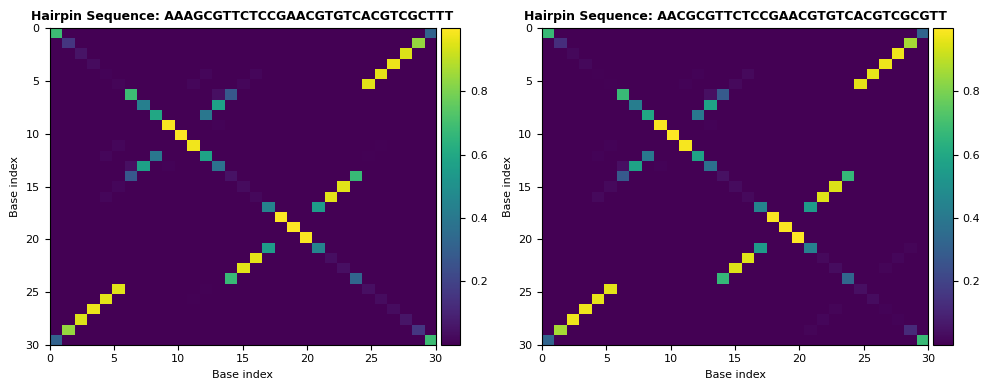

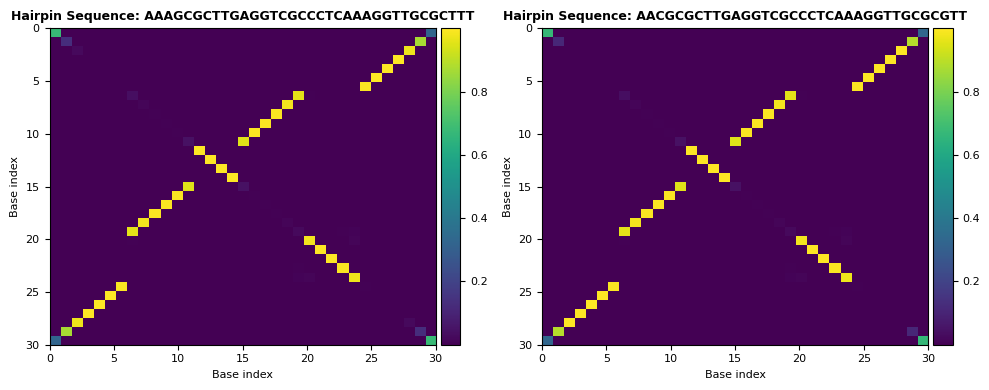

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
for ax, pb, hairpin, mmp9 in zip(axs.flat, sq2_controls_long['Hairpin_Pb'], sq2_controls_long['Hairpin'], sq2.gene_snippet):
    im = ax.imshow(pb, interpolation='nearest', cmap='viridis', aspect='auto', extent=[0,30,30,0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.xaxis.set_ticks_position('default')
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0.2, 0.4, 0.6, 0.8])
    cbar.ax.tick_params(labelsize=8)
    
    ax.set_title('Hairpin Sequence: ' + hairpin, fontsize=9, weight='bold')
    ax.set_xlabel('Base index', fontsize=8)
    ax.set_ylabel('Base index', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.grid(False)
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
for ax, pb, hairpin, mmp9 in zip(axs.flat, sq2_hairpins['Hairpin_Pb'], sq2_hairpins['Hairpin'], sq2.gene_snippet):
    im = ax.imshow(pb, interpolation='nearest', cmap='viridis', aspect='auto', extent=[0,30,30,0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.xaxis.set_ticks_position('default')
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0.2, 0.4, 0.6, 0.8])
    cbar.ax.tick_params(labelsize=8)
    
    ax.set_title('Hairpin Sequence: ' + hairpin, fontsize=9, weight='bold')
    ax.set_xlabel('Base index', fontsize=8)
    ax.set_ylabel('Base index', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.grid(False)
    
plt.tight_layout()
plt.show()


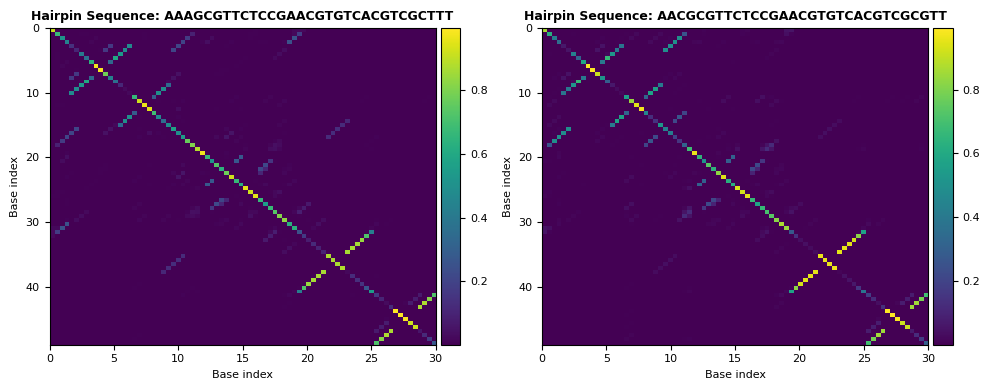

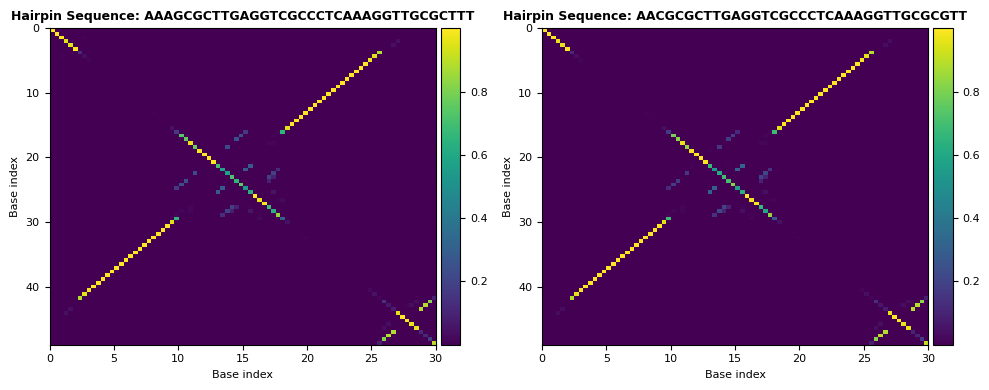

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
for ax, pb, hairpin, mmp9 in zip(axs.flat, sq2_controls_long['Hyb_Pb'], sq2_controls_long['Hairpin'], sq2.gene_snippet):
    im = ax.imshow(pb, interpolation='nearest', cmap='viridis', aspect='auto', extent=[0,30,len(sq2.gene_snippet),0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.xaxis.set_ticks_position('default')
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0.2, 0.4, 0.6, 0.8])
    cbar.ax.tick_params(labelsize=8)
    
    ax.set_title('Hairpin Sequence: ' + hairpin, fontsize=9, weight='bold')
    ax.set_xlabel('Base index', fontsize=8)
    ax.set_ylabel('Base index', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.grid(False)
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
for ax, pb, hairpin, mmp9 in zip(axs.flat, sq2_hairpins['Hyb_Pb'], sq2_hairpins['Hairpin'], sq2.gene_snippet):
    im = ax.imshow(pb, interpolation='nearest', cmap='viridis', aspect='auto', extent=[0,30,len(sq2.gene_snippet),0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.xaxis.set_ticks_position('default')
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0.2, 0.4, 0.6, 0.8])
    cbar.ax.tick_params(labelsize=8)
    
    ax.set_title('Hairpin Sequence: ' + hairpin, fontsize=9, weight='bold')
    ax.set_xlabel('Base index', fontsize=8)
    ax.set_ylabel('Base index', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.grid(False)
    
plt.tight_layout()
plt.show()


In [14]:
CCTGGGCAGATTCCAAACCTTTGAGGGCGACCTCAAGTGGCACCACCAC

# Third siRNA: sq3
if sq3.gene_snippet != np.NaN:
    sq3_hairpins = hairpin_dataset(sq3)
    sq3_hairpins = aso_model(sq3, sq3_hairpins)
    sq3_hairpins_optimised = clean_model(sq3_hairpins, False)
    print(sq3_hairpins_optimised)
else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq3.name)

NameError: name 'CCTGGGCAGATTCCAAACCTTTGAGGGCGACCTCAAGTGGCACCACCAC' is not defined

In [ ]:
# Fourth siRNA: sq4
if sq4.gene_snippet != np.NaN:
    sq4_hairpins = hairpin_dataset(sq4)
    sq4_hairpins = aso_model(sq4, sq4_hairpins)
    sq4_hairpins_optimised = clean_model(sq4_hairpins, False)
    print(sq4_hairpins_optimised)
else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq4.name)

In [ ]:
# Fifth siRNA: sq5
if sq5.gene_snippet != np.NaN:
    sq5_hairpins = hairpin_dataset(sq5)
    sq5_hairpins = aso_model(sq5, sq5_hairpins)
    sq5_hairpins_optimised = clean_model(sq5_hairpins, False)
    print(sq5_hairpins_optimised)
else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq5.name)

In [ ]:
# Sixth siRNA: sq6
if sq6.gene_snippet != np.NaN:
    sq6_hairpins = hairpin_dataset(sq6)
    sq6_hairpins = aso_model(sq6, sq6_hairpins)
    sq6_hairpins_optimised = clean_model(sq6_hairpins, False)
    print(sq6_hairpins_optimised)
else:
    print('There is no complementary sequence in your chosen Gene matching the silencing sequence given: ' + sq6.name)